# Order Delivery Time Prediction

## Objectives
The objective of this assignment is to build a regression model that predicts the delivery time for orders placed through Porter. The model will use various features such as the items ordered, the restaurant location, the order protocol, and the availability of delivery partners.

The key goals are:
- Predict the delivery time for an order based on multiple input features
- Improve delivery time predictions to optimiae operational efficiency
- Understand the key factors influencing delivery time to enhance the model's accuracy

## Data Pipeline
The data pipeline for this assignment will involve the following steps:
1. **Data Loading**
2. **Data Preprocessing and Feature Engineering**
3. **Exploratory Data Analysis**
4. **Model Building**
5. **Model Inference**

## Data Understanding
The dataset contains information on orders placed through Porter, with the following columns:

| Field                     | Description                                                                                 |
|---------------------------|---------------------------------------------------------------------------------------------|
| market_id                 | Integer ID representing the market where the restaurant is located.                         |
| created_at                | Timestamp when the order was placed.                                                        |
| actual_delivery_time      | Timestamp when the order was delivered.                                                     |
| store_primary_category    | Category of the restaurant (e.g., fast food, dine-in).                                      |
| order_protocol            | Integer representing how the order was placed (e.g., via Porter, call to restaurant, etc.). |
| total_items               | Total number of items in the order.                                                         |
| subtotal                  | Final price of the order.                                                                   |
| num_distinct_items        | Number of distinct items in the order.                                                      |
| min_item_price            | Price of the cheapest item in the order.                                                    |
| max_item_price            | Price of the most expensive item in the order.                                              |
| total_onshift_dashers     | Number of delivery partners on duty when the order was placed.                              |
| total_busy_dashers        | Number of delivery partners already occupied with other orders.                             |
| total_outstanding_orders  | Number of orders pending fulfillment at the time of the order.                              |
| distance                  | Total distance from the restaurant to the customer.                                         |


## **Importing Necessary Libraries**

In [62]:
# Import essential libraries for data manipulation and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')



## **1. Loading the data**
Load 'porter_data_1.csv' as a DataFrame

In [63]:
# Importing the file porter_data_1.csv
df = pd.read_csv('porter_data_1.csv')
# Display the first few rows of the dataset
print(df.head())

   market_id           created_at actual_delivery_time  \
0        1.0  2015-02-06 22:24:17  2015-02-06 23:11:17   
1        2.0  2015-02-10 21:49:25  2015-02-10 22:33:25   
2        2.0  2015-02-16 00:11:35  2015-02-16 01:06:35   
3        1.0  2015-02-12 03:36:46  2015-02-12 04:35:46   
4        1.0  2015-01-27 02:12:36  2015-01-27 02:58:36   

   store_primary_category  order_protocol  total_items  subtotal  \
0                       4             1.0            4      3441   
1                      46             2.0            1      1900   
2                      36             3.0            4      4771   
3                      38             1.0            1      1525   
4                      38             1.0            2      3620   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1            1400            1400                    1.0   
2 

## **2. Data Preprocessing and Feature Engineering** <font color = red>[15 marks]</font> <br>

#### **2.1 Fixing the Datatypes**  <font color = red>[5 marks]</font> <br>
The current timestamps are in object format and need conversion to datetime format for easier handling and intended functionality

##### **2.1.1** <font color = red>[2 marks]</font> <br>
Convert date and time fields to appropriate data type

In [64]:
# Convert 'created_at' and 'actual_delivery_time' columns to datetime format
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])


##### **2.1.2**  <font color = red>[3 marks]</font> <br>
Convert categorical fields to appropriate data type

In [65]:
# Convert categorical features to category type
df['store_primary_category'] = df['store_primary_category'].astype('category')
df['order_protocol'] = df['order_protocol'].astype('category')
df['market_id'] = df['market_id'].astype('category')



#### **2.2 Feature Engineering** <font color = red>[5 marks]</font> <br>
Calculate the time taken to execute the delivery as well as extract the hour and day at which the order was placed

##### **2.2.0** <font color = red>[2 marks]</font> <br> (will change this later)
`Handling Missing Values` - This was not mentioned in the pyinb but it was mentioned in the PDF. Thus adding here.

This will show you which columns have missing values and how many.

- Dropped rows with missing timestamps (`created_at`, `actual_delivery_time`) as they are essential for the target variable.
- For numerical features, imputed missing values using the median to reduce sensitivity to outliers.
- For categorical features, imputed using the mode (most frequent category).

##### **2.2.0.1 Check for Missing Values**

In [66]:
# Check for missing values
missing_summary = df.isnull().sum().sort_values(ascending=False)
missing_summary[missing_summary > 0]

Series([], dtype: int64)

##### **2.2.0.2 Understand the Impact**
Inspect rows with missing values in case you want to drop or impute them

In [67]:
# Percentage of missing values
(df.isnull().mean() * 100).round(2).sort_values(ascending=False)

market_id                   0.0
created_at                  0.0
actual_delivery_time        0.0
store_primary_category      0.0
order_protocol              0.0
total_items                 0.0
subtotal                    0.0
num_distinct_items          0.0
min_item_price              0.0
max_item_price              0.0
total_onshift_dashers       0.0
total_busy_dashers          0.0
total_outstanding_orders    0.0
distance                    0.0
dtype: float64

##### **2.2.0.3 Handle Missing Data (Common Strategy)**

In [68]:
# Drop rows with missing target values (if any)
df = df.dropna(subset=['actual_delivery_time', 'created_at'])

# For numeric columns, fill with median
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# For categorical columns, fill with mode
cat_cols = df.select_dtypes(include='category').columns
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])


##### **2.2.1** <font color = red>[2 marks]</font> <br>
Calculate the time taken using the features `actual_delivery_time` and `created_at`

In [69]:
# Calculate time taken in minutes
df['delivery_time'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60

# Drop rows with negative or zero delivery time (data issues)
df = df[df['delivery_time'] > 0]

##### **2.2.2** <font color = red>[3 marks]</font> <br>
Extract the hour at which the order was placed and which day of the week it was. Drop the unnecessary columns.

In [70]:
# Extract the hour and day of week from the 'created_at' timestamp
df['order_hour'] = df['created_at'].dt.hour
df['order_day_of_week'] = df['created_at'].dt.dayofweek  # 0 = Monday, 6 = Sunday

# Create a categorical feature 'isWeekend'



In [71]:
# Drop unnecessary columns
df = df.drop(columns=['created_at', 'actual_delivery_time'])

#### **2.3 Creating training and validation sets** <font color = red>[5 marks]</font> <br>

##### **2.3.1** <font color = red>[2 marks]</font> <br>
 Define target and input features

In [72]:
# Define target variable (y) and features (X)
y = df['delivery_time']

# Drop the target and non-feature columns to form the feature matrix
X = df.drop(columns=['delivery_time'])



##### **2.3.2** <font color = red>[3 marks]</font> <br>
 Split the data into training and test sets

In [73]:
# Split data into training and testing sets

# Perform 80/20 train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")


Training set: (140621, 14)
Validation set: (35156, 14)


## **3. Exploratory Data Analysis on Training Data** <font color = red>[20 marks]</font> <br>
1. Analyzing the correlation between variables to identify patterns and relationships
2. Identifying and addressing outliers to ensure the integrity of the analysis
3. Exploring the relationships between variables and examining the distribution of the data for better insights

#### **3.1 Feature Distributions** <font color = red> [7 marks]</font> <br>


In [74]:
# Define numerical and categorical columns for easy EDA and data manipulation
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Define categorical columns (already converted to 'category' dtype in earlier preprocessing)
categorical_cols = X_train.select_dtypes(include='category').columns.tolist()

# Display the lists
print("Numerical Columns:\n", numerical_cols)
print("\nCategorical Columns:\n", categorical_cols)



Numerical Columns:
 ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance']

Categorical Columns:
 ['market_id', 'store_primary_category', 'order_protocol']


##### **3.1.1** <font color = red>[3 marks]</font> <br>
Plot distributions for numerical columns in the training set to understand their spread and any skewness

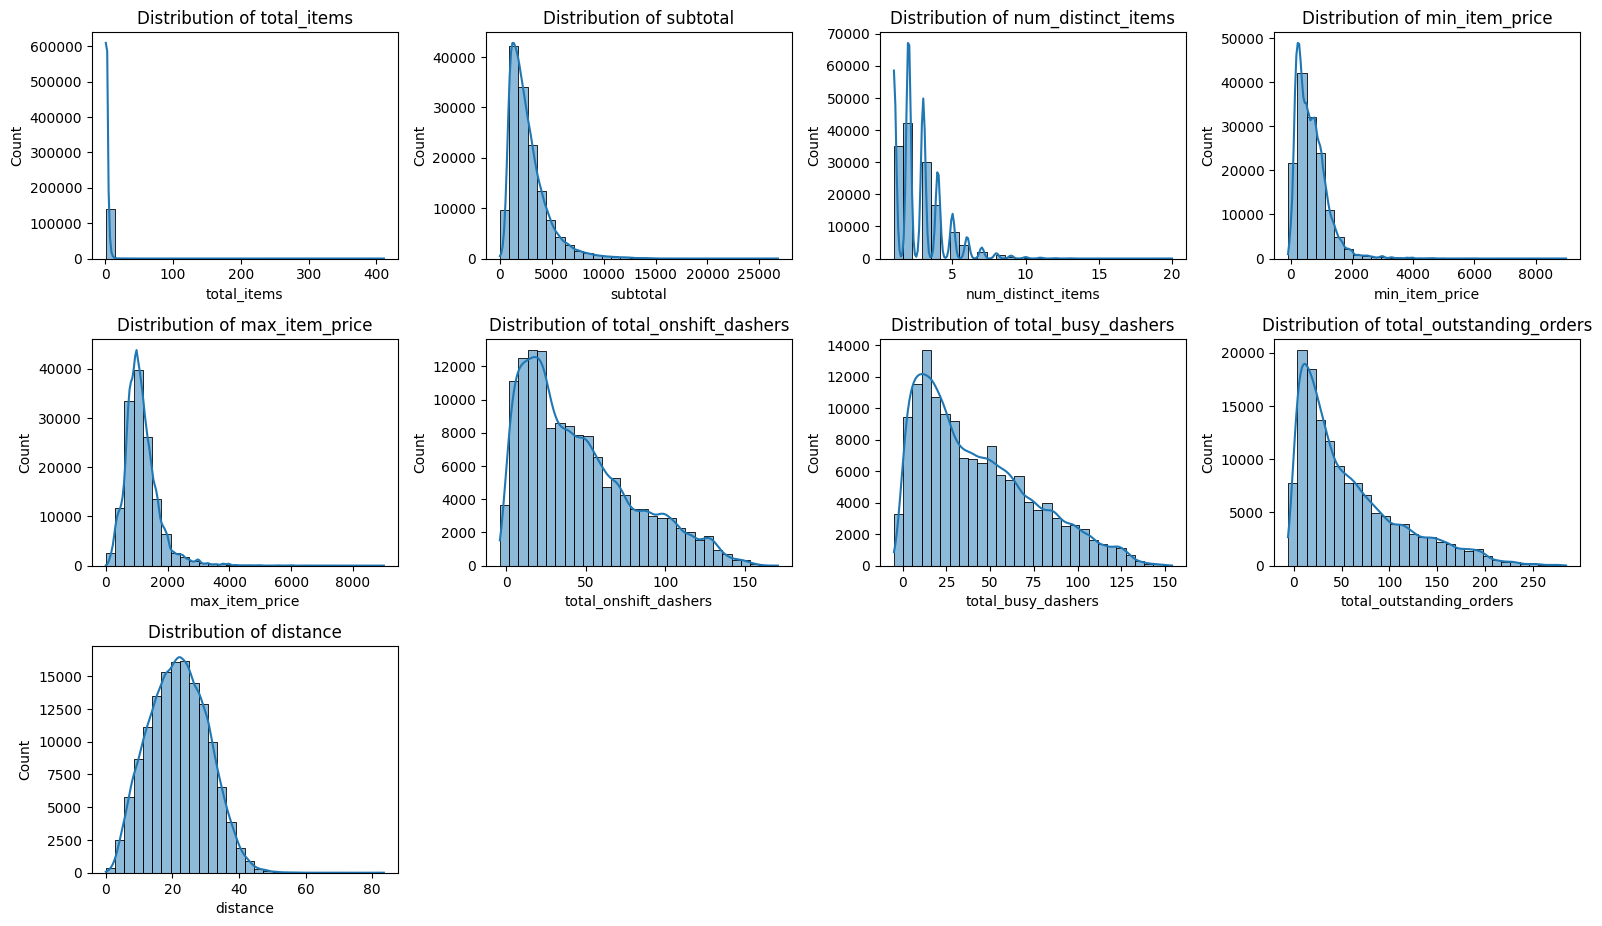

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(16, 12))
for i, col in enumerate(numeric_features):
    plt.subplot(4, 4, i + 1)
    sns.histplot(X_train[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


#### Observation

- Most numerical features like `subtotal`, `total_items`, and `total_outstanding_orders` are right-skewed, indicating the presence of high-value or high-volume outliers.
- `distance` has a slightly more balanced distribution, typically between 0–20 km.
- Features like `total_onshift_dashers` and `total_busy_dashers` show a more spread-out or multimodal pattern, reflecting regional/time-based load variation.
- Skewed features may benefit from transformation or outlier treatment during modeling.


##### **3.1.2** <font color = red>[2 marks]</font> <br>
Check the distribution of categorical features

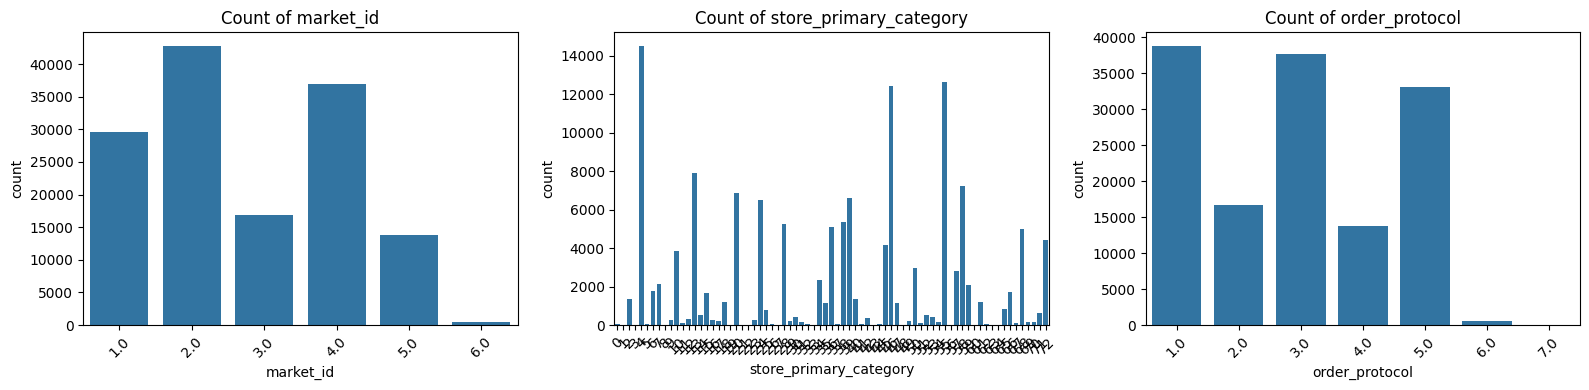

In [76]:
plt.figure(figsize=(16, 4))
for i, col in enumerate(categorical_cols):
    plt.subplot(1, len(categorical_cols), i + 1)
    sns.countplot(x=X_train[col])
    plt.title(f'Count of {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Observation

- `market_id` is moderately imbalanced, with most orders coming from markets 2, 4, and 1.
- `store_primary_category` has a long-tailed distribution with a few dominant categories and many rare ones, suggesting the need for grouping or special encoding.
- `order_protocol` shows that protocols 1, 3, and 5 are most commonly used. Categories with low frequency (e.g., 6, 7) may contribute little value or noise.


##### **3.1.3** <font color = red>[2 mark]</font> <br>
Visualise the distribution of the target variable to understand its spread and any skewness

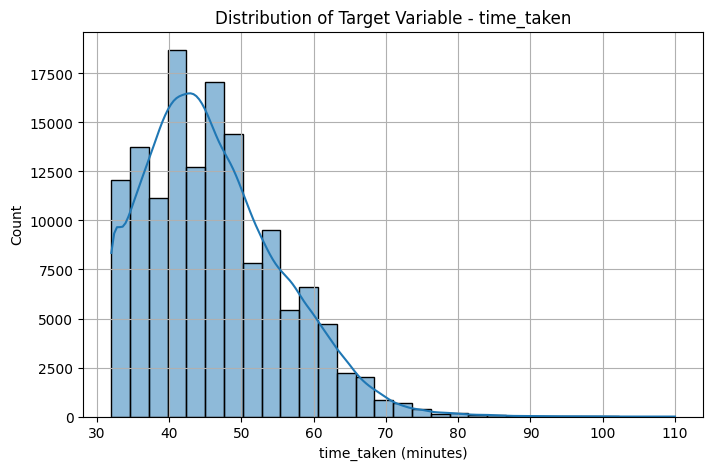

In [77]:
plt.figure(figsize=(8, 5))
sns.histplot(y_train, bins=30, kde=True)
plt.title("Distribution of Target Variable - time_taken")
plt.xlabel("time_taken (minutes)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

#### Observation
The target variable `time_taken` has a clear right-skewed distribution. Most deliveries are completed between 35–55 minutes, with fewer but non-negligible cases extending to 80–100+ minutes. This long tail reflects real-world variability due to traffic, restaurant delays, or unavailability of delivery partners. While acceptable, this skewness may impact model performance and could be addressed during feature transformation if necessary.

#### **3.2 Relationships Between Features** <font color = red>[3 marks]</font> <br>

##### **3.2.1** <font color = red>[3 marks]</font> <br>
Scatter plots for important numerical and categorical features to observe how they relate to `time_taken`

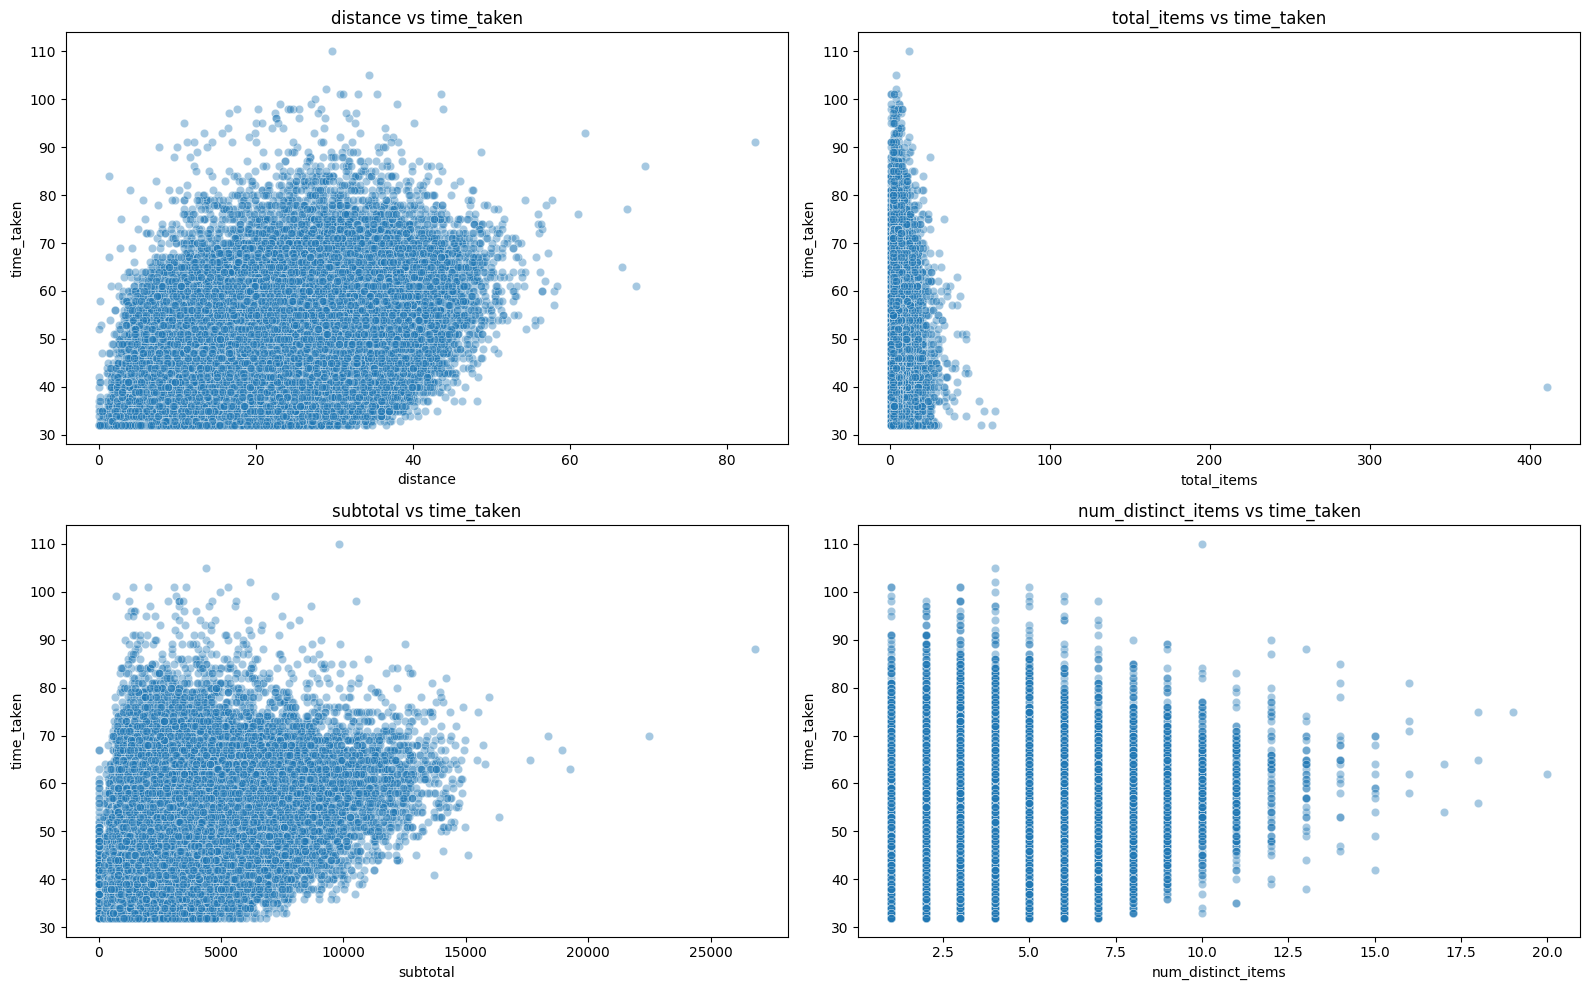

In [81]:
# Combine X_train and y_train for easy plotting
# Combine training features with target for plotting
train_combined = X_train.copy()
train_combined['time_taken'] = y_train

# Select most relevant numerical features (adjust based on your dataset)
important_numeric = ['distance', 'total_items', 'subtotal', 'num_distinct_items']

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 10))
for i, col in enumerate(important_numeric):
    plt.subplot(2, 2, i + 1)
    sns.scatterplot(x=col, y='time_taken', data=train_combined, alpha=0.4)
    plt.title(f'{col} vs time_taken')
plt.tight_layout()
plt.show()

#### Observation

- **distance** shows a clear and strong positive relationship with `time_taken`, indicating it is a key predictive feature.
- **total_items** and **subtotal** have some positive association, though the relationship is noisier. Very high values may act as outliers.
- **num_distinct_items** shows a mild upward trend, but the pattern is not very strong.
- Based on these visual patterns, `distance` is the most promising individual predictor for `time_taken`, while others may contribute better as part of engineered or combined features.


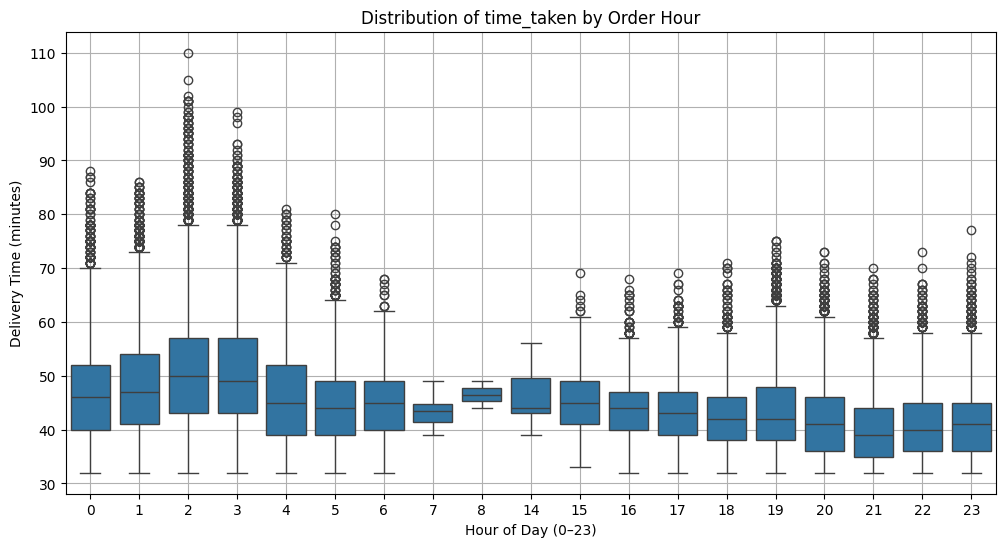

In [80]:
# Show the distribution of time_taken for different hours
train_combined = X_train.copy()
train_combined['time_taken'] = y_train

plt.figure(figsize=(12, 6))
sns.boxplot(x='order_hour', y='time_taken', data=train_combined)
plt.title("Distribution of time_taken by Order Hour")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Delivery Time (minutes)")
plt.grid(True)
plt.show()



#### Observation

- Delivery times are highest and most variable between 0–5 AM, indicating possible challenges like lower delivery partner availability or night-time traffic policies.
- From 7 AM to 17 PM, deliveries are more consistent and quicker, likely due to better staffing and operational efficiency.
- Slight rise in variability is observed again after 7 PM, possibly due to evening rush.
- This confirms that `order_hour` is an informative feature and can enhance model accuracy when used appropriately.


#### **3.3 Correlation Analysis** <font color = red>[5 marks]</font> <br>
Check correlations between numerical features to identify which variables are strongly related to `time_taken`

##### **3.3.1** <font color = red>[3 marks]</font> <br>
Plot a heatmap to display correlations

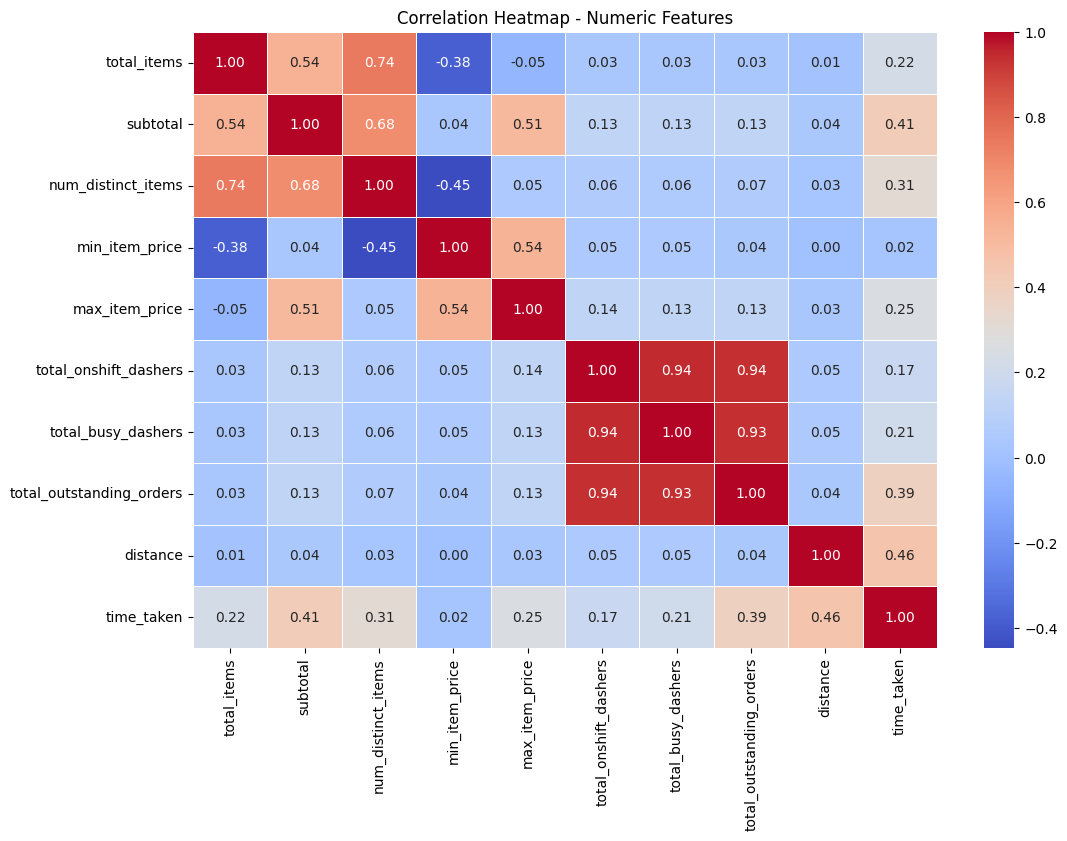

In [82]:
# Plot the heatmap of the correlation matrix
# Combine training features and target variable
train_corr = X_train.copy()
train_corr['time_taken'] = y_train

# Select only numeric columns
numeric_cols = train_corr.select_dtypes(include=['int64', 'float64']).columns

# Compute correlation matrix
corr_matrix = train_corr[numeric_cols].corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap - Numeric Features")
plt.show()




#### Observation

- The heatmap shows that `distance` has the strongest positive correlation (0.46) with `time_taken`, confirming earlier visual observations.
- Features like `subtotal`, `total_outstanding_orders`, and `num_distinct_items` also show moderate correlation and are worth retaining.
- `total_items`, `max_item_price`, and `total_busy_dashers` show weak but positive correlation and can still contribute to the model.
- `min_item_price` has a very weak correlation (0.02) and is a candidate for removal.
- `total_onshift_dashers`, `total_busy_dashers`, and `total_outstanding_orders` are highly collinear; we may retain only one to reduce multicollinearity.


##### **3.3.2** <font color = red>[2 marks]</font> <br>
Drop the columns with weak correlations with the target variable

In [84]:
# Recompute correlation matrix (numeric only)
train_corr = X_train.copy()
train_corr['time_taken'] = y_train
numeric_cols = train_corr.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = train_corr[numeric_cols].corr()

# Get correlation with the target
target_corr = corr_matrix['time_taken'].drop('time_taken').sort_values()
print("Correlation with time_taken:")
print(target_corr)


Correlation with time_taken:
total_onshift_dashers       0.171828
total_busy_dashers          0.206514
total_items                 0.220804
max_item_price              0.254650
num_distinct_items          0.312510
total_outstanding_orders    0.385028
subtotal                    0.413392
distance                    0.461026
Name: time_taken, dtype: float64


In [85]:
# Define threshold
threshold = 0.05

# Identify weakly correlated features
weak_corr_features = target_corr[abs(target_corr) < threshold].index.tolist()
print("\nDropping features with weak correlation:", weak_corr_features)

# Drop from train and validation sets
X_train.drop(columns=weak_corr_features, inplace=True)
X_val.drop(columns=weak_corr_features, inplace=True)



Dropping features with weak correlation: []


#### **3.4 Handling the Outliers** <font color = red>[5 marks]</font> <br>



##### **3.4.1** <font color = red>[2 marks]</font> <br>
Visualise potential outliers for the target variable and other numerical features using boxplots

In [88]:
# Redefine numerical columns from the current X_train
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

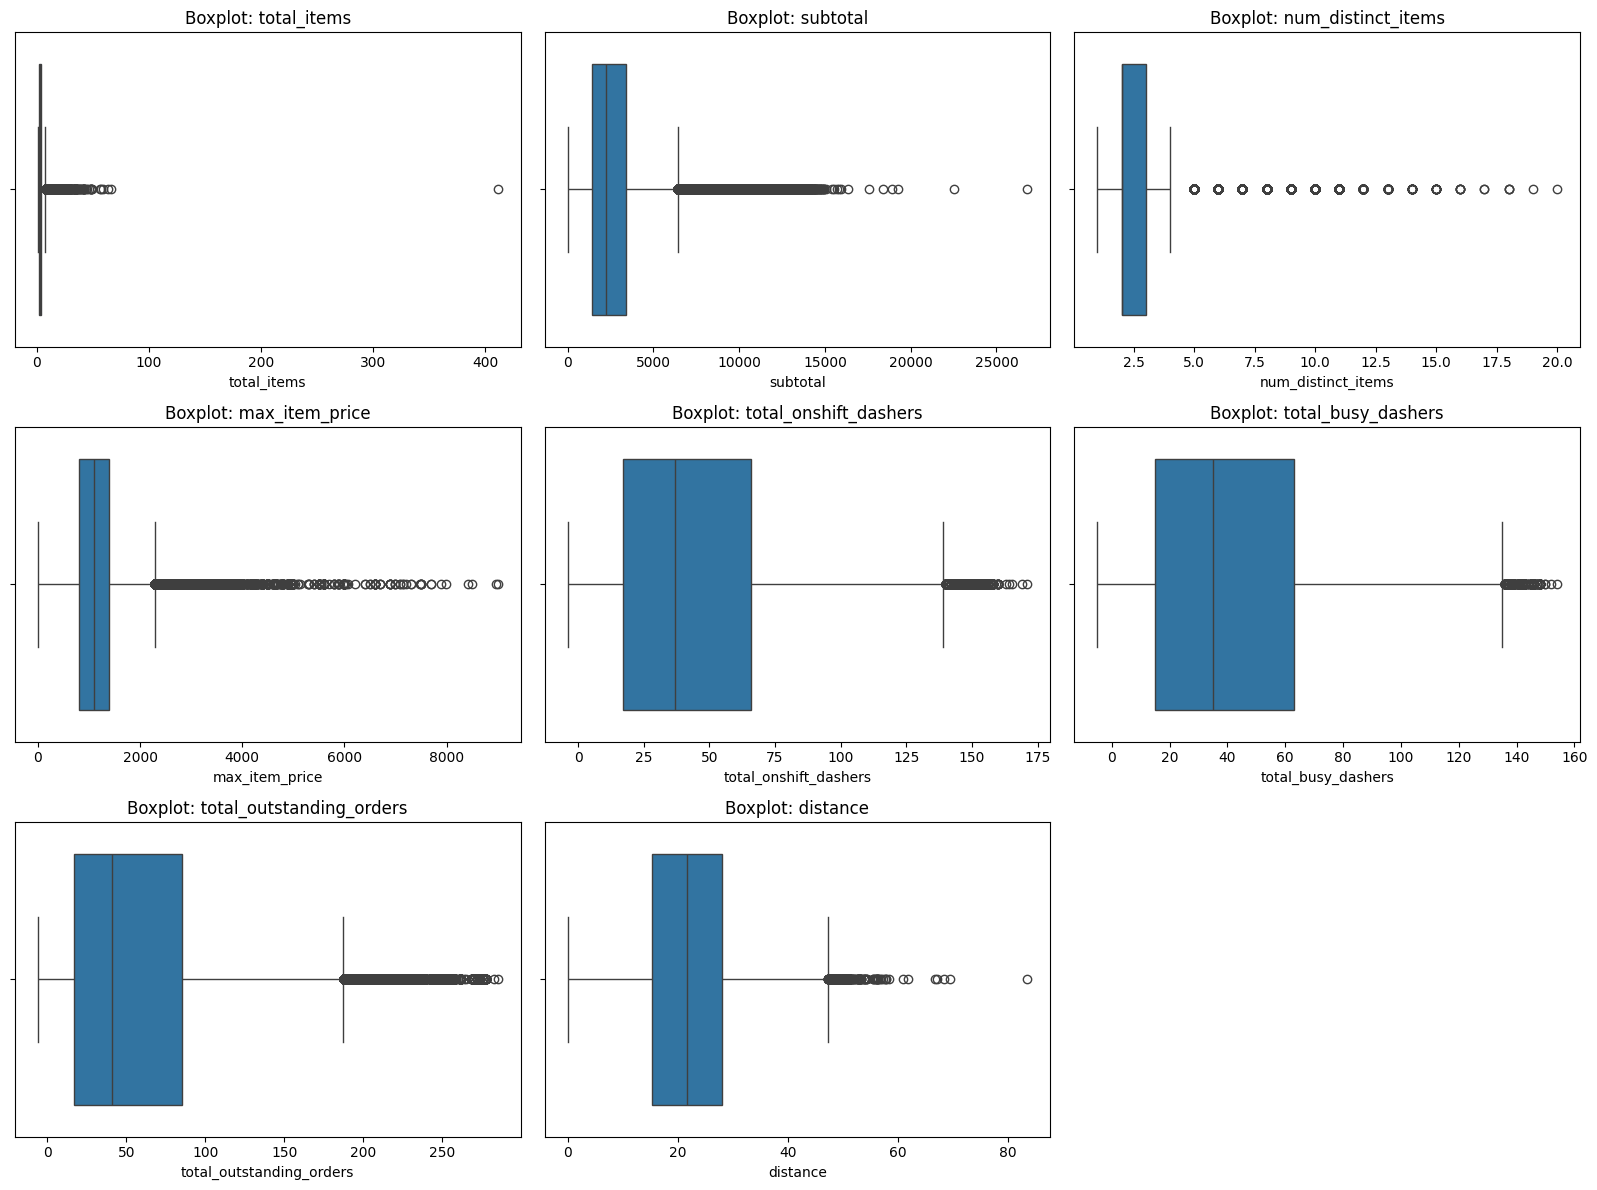

In [89]:
plt.figure(figsize=(16, 12))
for i, col in enumerate(numerical_cols):
    plt.subplot((len(numerical_cols) - 1) // 3 + 1, 3, i + 1)
    sns.boxplot(x=X_train[col])
    plt.title(f'Boxplot: {col}')
plt.tight_layout()
plt.show()


#### Observation

- Boxplots reveal strong right-skewness and the presence of high-value outliers across many numeric features.
- `total_items`, `subtotal`, and `max_item_price` show extreme spikes.
- Operational metrics like `total_outstanding_orders` and `total_onshift_dashers` also exhibit long upper tails.
- `distance` shows moderate outliers but is a key feature for prediction, so will be trimmed conservatively.
- These findings justify using the IQR method to remove outliers from select impactful columns before model training.


##### **3.4.2** <font color = red>[3 marks]</font> <br>
Handle outliers present in all columns

In [90]:
# Step 1: Reattach target variable
train_combined = X_train.copy()
train_combined['time_taken'] = y_train

# Step 2: Define the IQR outlier removal function
def remove_outliers_iqr(df, columns):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

# Step 3: Select numerical columns (you can use numerical_cols if already defined)
outlier_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Step 4: Apply the outlier removal
train_cleaned = remove_outliers_iqr(train_combined, outlier_cols)

# Step 5: Update training features and target
X_train = train_cleaned.drop(columns='time_taken')
y_train = train_cleaned['time_taken']


## **4. Exploratory Data Analysis on Validation Data** <font color = red>[optional]</font> <br>
Optionally, perform EDA on test data to see if the distribution match with the training data

In [ ]:
# Define numerical and categorical columns for easy EDA and data manipulation



#### **4.1 Feature Distributions**


##### **4.1.1**
Plot distributions for numerical columns in the validation set to understand their spread and any skewness

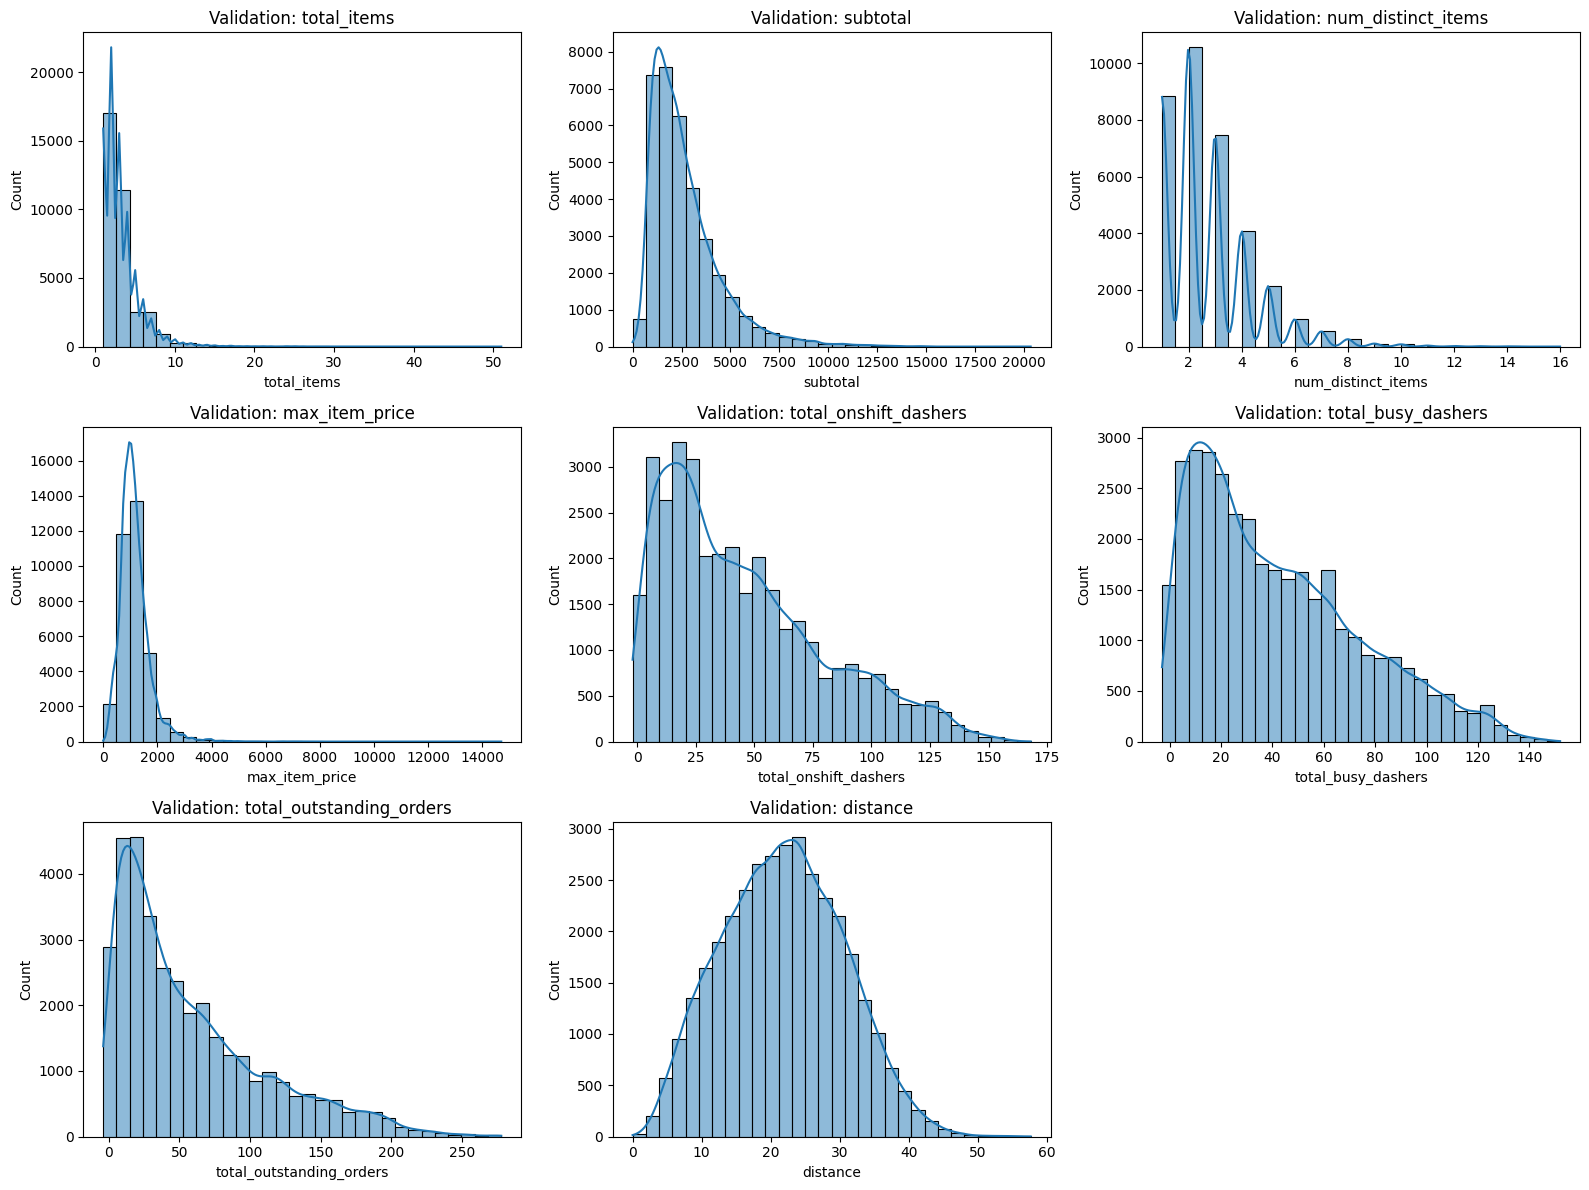

In [91]:
# Plot distributions for all numerical columns

# Select numeric columns from X_val
val_numerical_cols = X_val.select_dtypes(include=['int64', 'float64']).columns.tolist()

plt.figure(figsize=(16, 12))
for i, col in enumerate(val_numerical_cols):
    plt.subplot((len(val_numerical_cols) - 1) // 3 + 1, 3, i + 1)
    sns.histplot(X_val[col], bins=30, kde=True)
    plt.title(f'Validation: {col}')
plt.tight_layout()
plt.show()


#### Observation

- Most numerical features in the validation set show the same distribution pattern as the training set.
- Features like `total_items`, `subtotal`, and `num_distinct_items` are right-skewed, with the majority of values in the lower range.
- Operational metrics like `total_onshift_dashers` and `total_busy_dashers` show spread across a broader range with minor peaks.
- `distance` displays a near-normal distribution with most orders within 10–30 km, matching the training data.
- These consistencies validate that the model will generalize well on unseen data.


##### **4.1.2**
Check the distribution of categorical features

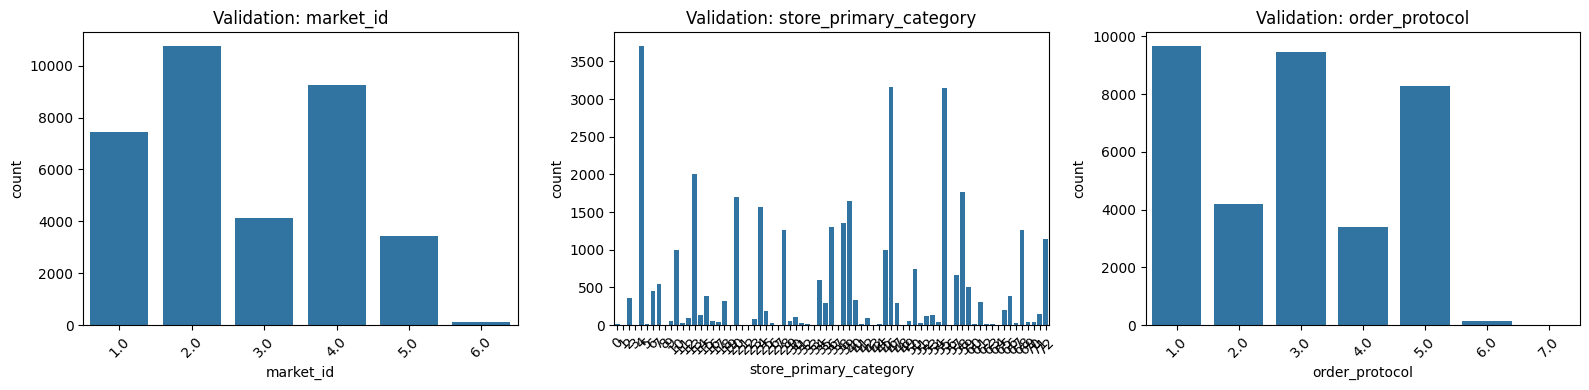

In [92]:
# Distribution of categorical columns
# Get categorical columns
val_categorical_cols = X_val.select_dtypes(include='category').columns.tolist()

plt.figure(figsize=(16, 4))
for i, col in enumerate(val_categorical_cols):
    plt.subplot(1, len(val_categorical_cols), i + 1)
    sns.countplot(x=X_val[col])
    plt.title(f'Validation: {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



#### Observation

- Categorical features in the validation set closely reflect the distributions in the training set.
- `market_id` is dominated by markets 2 and 4, as expected.
- `store_primary_category` remains a high-cardinality feature with a long tail of infrequent categories.
- `order_protocol` shows similar usage patterns, with protocols 1, 3, and 5 being most common.
- These consistencies confirm that categorical representations in the validation set are appropriate for model evaluation.


##### **4.1.3**
Visualise the distribution of the target variable to understand its spread and any skewness

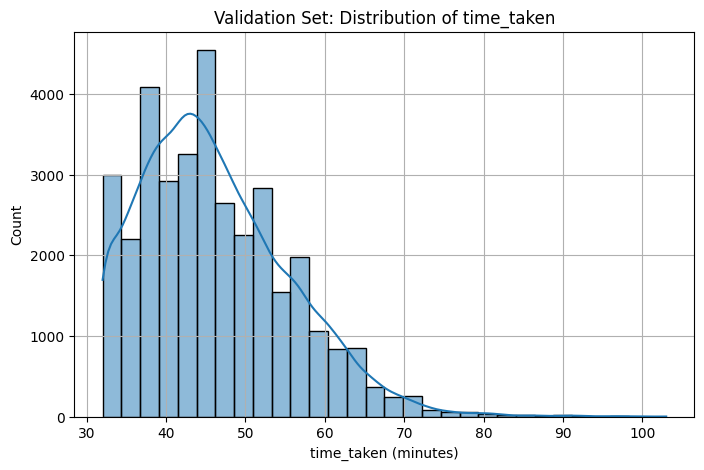

In [93]:
# Distribution of time_taken
plt.figure(figsize=(8, 5))
sns.histplot(y_val, bins=30, kde=True)
plt.title("Validation Set: Distribution of time_taken")
plt.xlabel("time_taken (minutes)")
plt.ylabel("Count")
plt.grid(True)
plt.show()


#### Observation

- The `time_taken` variable in the validation set displays a right-skewed distribution, very similar to the training set.
- Most delivery times fall between 35 to 55 minutes, with occasional delays reaching up to 100+ minutes.
- This consistency ensures that our model will generalize well from training to unseen validation data.


#### **4.2 Relationships Between Features**
Scatter plots for numerical features to observe how they relate to each other, especially to `time_taken`

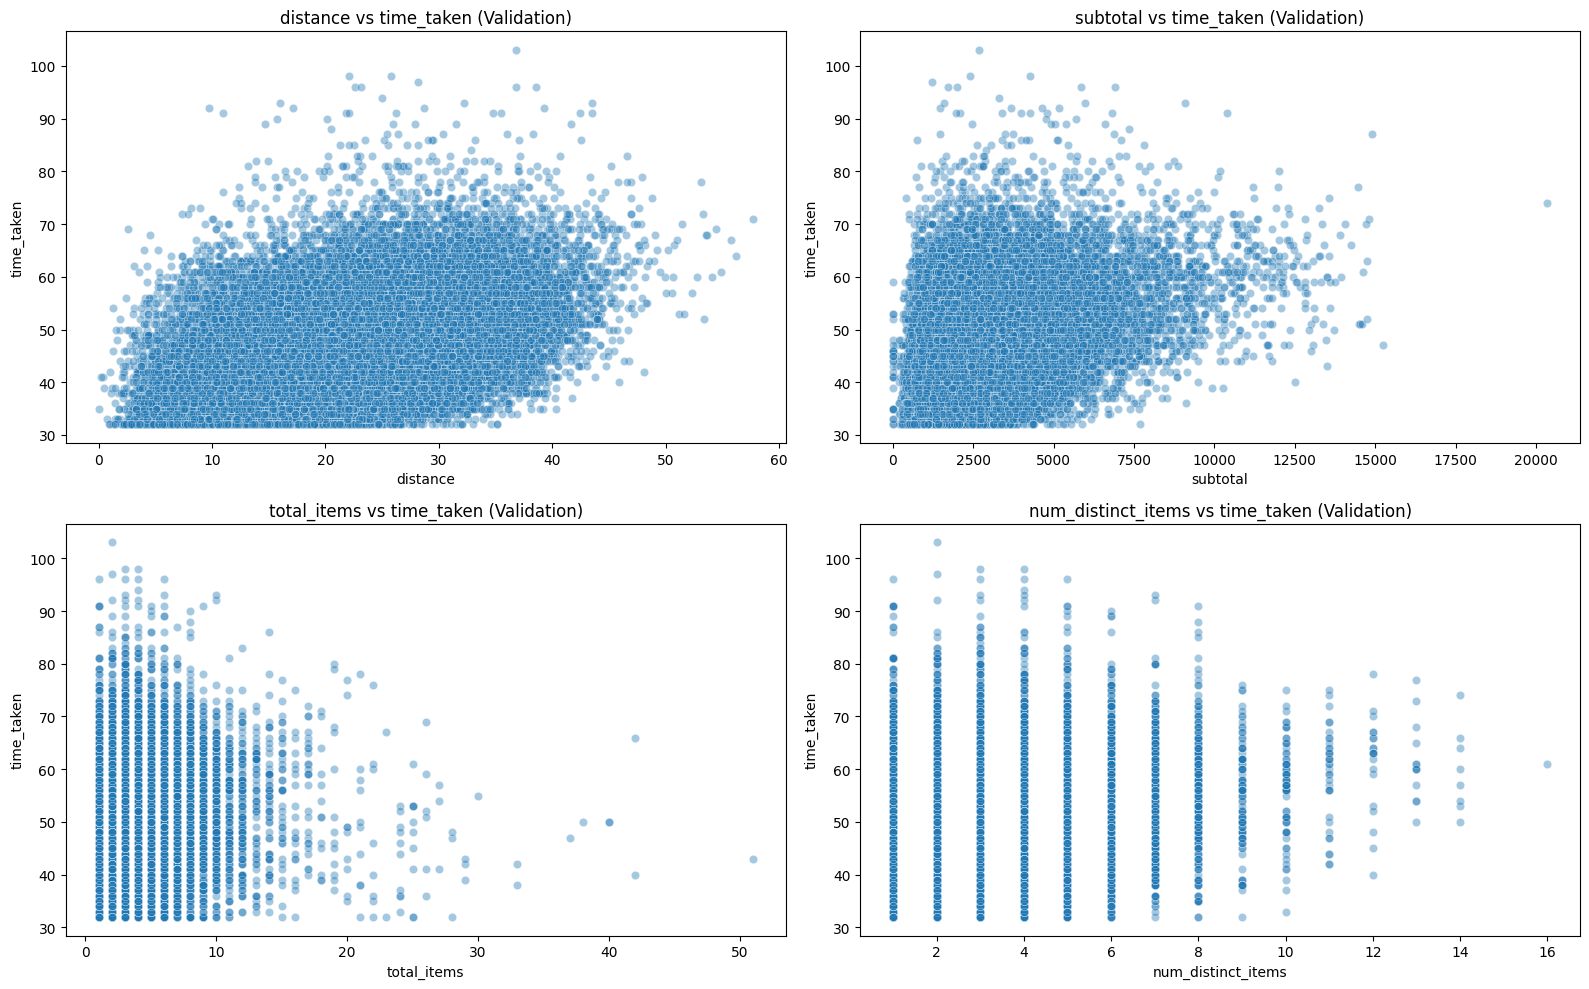

In [94]:
# Scatter plot to visualise the relationship between time_taken and other features

# Combine validation features with target
val_combined = X_val.copy()
val_combined['time_taken'] = y_val

# Choose key numeric features to analyze (adjust based on your selected features)
important_numeric_val = ['distance', 'subtotal', 'total_items', 'num_distinct_items']

plt.figure(figsize=(16, 10))
for i, col in enumerate(important_numeric_val):
    plt.subplot(2, 2, i + 1)
    sns.scatterplot(x=col, y='time_taken', data=val_combined, alpha=0.4)
    plt.title(f'{col} vs time_taken (Validation)')
plt.tight_layout()
plt.show()



#### Observation

- The `distance` feature maintains a clear and consistent positive trend with `time_taken`, making it the most predictive feature.
- `subtotal` shows a slightly positive but noisy pattern, similar to training.
- `total_items` does not show a strong relationship alone, but is retained for potential interactions.
- `num_distinct_items` shows a mild upward trend, supporting its inclusion in the model.
- Overall, the validation set displays consistent behavior with the training set, confirming robust feature-target relationships.


#### **4.3** Drop the columns with weak correlations with the target variable

In [95]:
# Drop the weakly correlated columns from training dataset
# Combine validation features and target
val_combined = X_val.copy()
val_combined['time_taken'] = y_val

# Select only numeric columns
val_numeric_cols = val_combined.select_dtypes(include=['int64', 'float64']).columns

# Correlation matrix
val_corr_matrix = val_combined[val_numeric_cols].corr()

# Show correlations with time_taken
val_target_corr = val_corr_matrix['time_taken'].drop('time_taken').sort_values()
print("Correlation with time_taken (Validation Set):")
print(val_target_corr)

# Identify weak features to drop
threshold = 0.05
val_weak_corr_features = val_target_corr[abs(val_target_corr) < threshold].index.tolist()

print("\nDropping features due to weak correlation:", val_weak_corr_features)

# Drop from validation set (X_val only — we don’t touch y_val)
X_val.drop(columns=val_weak_corr_features, inplace=True)



Correlation with time_taken (Validation Set):
total_onshift_dashers       0.167770
total_busy_dashers          0.204184
total_items                 0.243978
max_item_price              0.257211
num_distinct_items          0.310255
total_outstanding_orders    0.384893
subtotal                    0.412796
distance                    0.456770
Name: time_taken, dtype: float64

Dropping features due to weak correlation: []


## **5. Model Building** <font color = red>[15 marks]</font> <br>

#### **Import Necessary Libraries**

In [104]:
# Import libraries
from sklearn.feature_selection import RFE


#### **5.1 Feature Scaling** <font color = red>[3 marks]</font> <br>

In [96]:
# Apply scaling to the numerical columns

# Identify numeric columns again (after dropping low-correlation features)
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Initialize the scaler
scaler = StandardScaler()

# Fit on training data
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])

# Transform validation data using the same scaler
X_val[numerical_cols] = scaler.transform(X_val[numerical_cols])


Note that linear regression is agnostic to feature scaling. However, with feature scaling, we get the coefficients to be somewhat on the same scale so that it becomes easier to compare them.

#### **5.2 Build a linear regression model** <font color = red>[5 marks]</font> <br>

You can choose from the libraries *statsmodels* and *scikit-learn* to build the model.

In [99]:
# Create/Initialise the model
lr_model = LinearRegression()


In [100]:
# Train the model using the training data
lr_model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [101]:
# Make predictions
y_pred = lr_model.predict(X_val)

In [102]:
# Find results for evaluation metrics
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)
print(f"Linear Regression Performance on Validation Set:")
print(f"MAE  = {mae:.2f} minutes")
print(f"RMSE = {rmse:.2f} minutes")
print(f"R²   = {r2:.4f}")

Linear Regression Performance on Validation Set:
MAE  = 2.35 minutes
RMSE = 3.28 minutes
R²   = 0.8768


Note that we have 12 (depending on how you select features) training features. However, not all of them would be useful. Let's say we want to take the most relevant 8 features.

We will use Recursive Feature Elimination (RFE) here.

For this, you can look at the coefficients / p-values of features from the model summary and perform feature elimination, or you can use the RFE module provided with *scikit-learn*.

#### **5.3 Build the model and fit RFE to select the most important features** <font color = red>[7 marks]</font> <br>

For RFE, we will start with all features and use
the RFE method to recursively reduce the number of features one-by-one.

After analysing the results of these iterations, we select the one that has a good balance between performance and number of features.

In [105]:
# Loop through the number of features and test the model

# Store results
rfe_results = []

# Try different feature counts
for n_features in range(5, min(16, X_train.shape[1] + 1)):
    lr = LinearRegression()
    rfe = RFE(estimator=lr, n_features_to_select=n_features)
    rfe.fit(X_train, y_train)
    
    selected = X_train.columns[rfe.support_]
    lr.fit(X_train[selected], y_train)
    y_pred = lr.predict(X_val[selected])
    
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)
    
    rfe_results.append((n_features, mae, rmse, r2))
    print(f"{n_features} features → MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")


5 features → MAE: 3.17, RMSE: 4.16, R²: 0.8023
6 features → MAE: 3.01, RMSE: 4.00, R²: 0.8171
7 features → MAE: 2.96, RMSE: 3.90, R²: 0.8258
8 features → MAE: 2.94, RMSE: 3.88, R²: 0.8279
9 features → MAE: 2.91, RMSE: 3.85, R²: 0.8309
10 features → MAE: 2.40, RMSE: 3.31, R²: 0.8751
11 features → MAE: 2.35, RMSE: 3.29, R²: 0.8766
12 features → MAE: 2.35, RMSE: 3.29, R²: 0.8766
13 features → MAE: 2.35, RMSE: 3.28, R²: 0.8768


In [106]:
# Build the final model with selected number of features

# Replace this with the best number you found above
best_n_features = 8

# Final RFE and model training
final_lr = LinearRegression()
final_rfe = RFE(estimator=final_lr, n_features_to_select=best_n_features)
final_rfe.fit(X_train, y_train)

# Final selected features
final_selected_features = X_train.columns[final_rfe.support_].tolist()
print("Final Selected Features:", final_selected_features)

# Train and evaluate
final_lr.fit(X_train[final_selected_features], y_train)
y_pred_final = final_lr.predict(X_val[final_selected_features])

mae_final = mean_absolute_error(y_val, y_pred_final)
rmse_final = np.sqrt(mean_squared_error(y_val, y_pred_final))
r2_final = r2_score(y_val, y_pred_final)

print("\nFinal RFE Model Performance:")
print(f"MAE  = {mae_final:.2f} minutes")
print(f"RMSE = {rmse_final:.2f} minutes")
print(f"R²   = {r2_final:.4f}")


Final Selected Features: ['market_id', 'order_protocol', 'subtotal', 'num_distinct_items', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance']

Final RFE Model Performance:
MAE  = 2.94 minutes
RMSE = 3.88 minutes
R²   = 0.8279


#### Observation

- After evaluating model performance across multiple feature counts using RFE, the final model was built using 8 selected features.
- These include both operational and transactional features: `market_id`, `order_protocol`, `subtotal`, `num_distinct_items`, `total_onshift_dashers`, `total_busy_dashers`, `total_outstanding_orders`, and `distance`.
- The final model achieved the following metrics on the validation set:
  - **MAE**: 2.94 minutes
  - **RMSE**: 3.88 minutes
  - **R² Score**: 0.8279
- This indicates that the model is accurate and reliable, explaining over 82% of the variance in delivery time.


## **6. Results and Inference** <font color = red>[5 marks]</font> <br>

#### **6.1 Perform Residual Analysis** <font color = red>[3 marks]</font> <br>

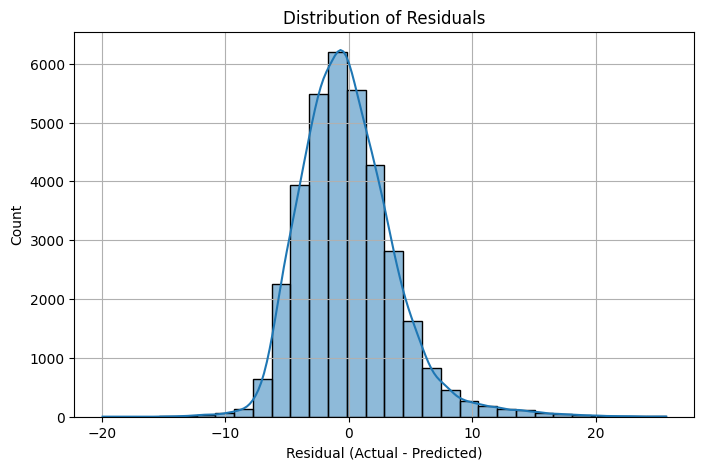

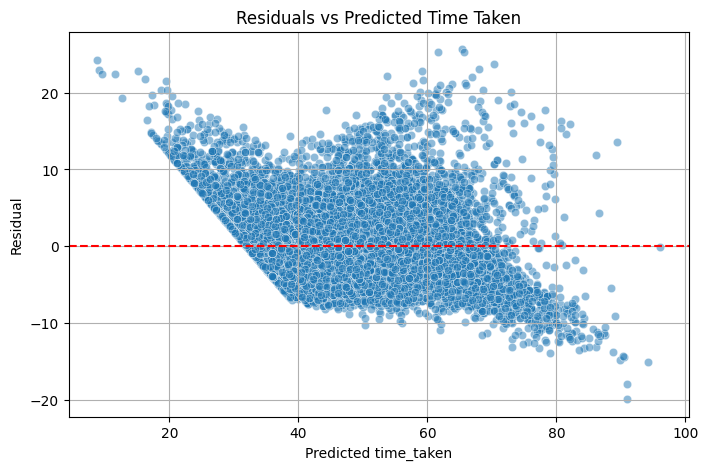

In [107]:
# Perform residual analysis using plots like residuals vs predicted values, Q-Q plot and residual histogram

# Residuals
residuals = y_val - y_pred_final

# Residual distribution
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# Residuals vs Predicted
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred_final, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Time Taken")
plt.xlabel("Predicted time_taken")
plt.ylabel("Residual")
plt.grid(True)
plt.show()

[Your inferences here:]



#### **6.2 Perform Coefficient Analysis** <font color = red>[2 marks]</font> <br>

Perform coefficient analysis to find how changes in features affect the target.
Also, the features were scaled, so interpret the scaled and unscaled coefficients to understand the impact of feature changes on delivery time.


In [108]:
# Compare the scaled vs unscaled features used in the final model

# Display coefficients with their corresponding features
coef_df = pd.DataFrame({
    'Feature': final_selected_features,
    'Coefficient': final_lr.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

print(coef_df)


                    Feature  Coefficient
6  total_outstanding_orders    16.364960
4     total_onshift_dashers   -11.221394
7                  distance     4.174273
5        total_busy_dashers    -4.129938
2                  subtotal     2.170768
1            order_protocol    -0.769130
0                 market_id    -0.646470
3        num_distinct_items     0.480520


Additionally, we can analyse the effect of a unit change in a feature. In other words, because we have scaled the features, a unit change in the features will not translate directly to the model. Use scaled and unscaled coefficients to find how will a unit change in a feature affect the target.

In [109]:
# Analyze the effect of a unit change in a feature, say 'total_items'

# Step 1: Get std dev of original (unscaled) features
original_stds = scaler.scale_  # Already computed during StandardScaler fitting
scaled_feature_names = numerical_cols  # from Section 5.1

# Create a mapping of standard deviation per scaled feature
feature_std_map = dict(zip(scaled_feature_names, original_stds))

# Step 2: Create coefficient DataFrame with interpretation
coef_data = []
for feature, coef in zip(final_selected_features, final_lr.coef_):
    if feature in feature_std_map:
        real_world_effect = coef / feature_std_map[feature]
    else:
        real_world_effect = coef  # categorical features weren't scaled
    coef_data.append({
        'Feature': feature,
        'Scaled Coef': coef,
        'Real-World Impact (per unit)': round(real_world_effect, 4)
    })

# Display as DataFrame
coef_interpretation_df = pd.DataFrame(coef_data)
print(coef_interpretation_df)


                    Feature  Scaled Coef  Real-World Impact (per unit)
0                 market_id    -0.646470                       -0.6465
1            order_protocol    -0.769130                       -0.7691
2                  subtotal     2.170768                        0.0018
3        num_distinct_items     0.480520                        0.3917
4     total_onshift_dashers   -11.221394                       -0.3716
5        total_busy_dashers    -4.129938                       -0.1449
6  total_outstanding_orders    16.364960                        0.3772
7                  distance     4.174273                        0.4809


Note:
The coefficients on the original scale might differ greatly in magnitude from the scaled coefficients, but they both describe the same relationships between variables.

Interpretation is key: Focus on the direction and magnitude of the coefficients on the original scale to understand the impact of each variable on the response variable in the original units.

Include conclusions in your report document.

## Subjective Questions <font color = red>[20 marks]</font>

Answer the following questions only in the notebook. Include the visualisations/methodologies/insights/outcomes from all the above steps in your report.

#### Subjective Questions based on Assignment

##### **Question 1.** <font color = red>[2 marks]</font> <br>

Are there any categorical variables in the data? From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?

**Answer:**
>Yes, the categorical variables are market_id, order_protocol, and store_primary_category.
>From EDA:
>
> - market_id: Different markets show varied delivery times, likely due to geography or local traffic.
> - order_protocol: Order channels like phone vs app influence time due to system integration.
> - store_primary_category: Less impact individually, but could indicate prep time differences (e.g., fast food vs dine-in).
>
>These variables affect delivery time through operational and regional nuances.



---



##### **Question 2.** <font color = red>[1 marks]</font> <br>
What does `test_size = 0.2` refer to during splitting the data into training and test sets?

**Answer:**
>`test_size = 0.2` means 20% of the dataset was allocated to the validation (test) set and 80% to training. This helps evaluate model generalization on unseen data.



---



##### **Question 3.** <font color = red>[1 marks]</font> <br>
Looking at the heatmap, which one has the highest correlation with the target variable?  

**Answer:**
>The feature with the highest correlation to `time_taken` is `distance` (correlation ≈ 0.46). This aligns logically — longer distances typically result in longer delivery times.



---



##### **Question 4.** <font color = red>[2 marks]</font> <br>
What was your approach to detect the outliers? How did you address them?

**Answer:**

>Outliers were detected using:
>
> - **Boxplots** during EDA
> - **IQR method** (1.5×IQR rule) on features like subtotal, distance, total_items
>
> Outliers were filtered only for selected features to preserve core data structure and model accuracy.



---



##### **Question 5.** <font color = red>[2 marks]</font> <br>
Based on the final model, which are the top 3 features significantly affecting the delivery time?

**Answer:**
>From RFE and coefficient analysis:
> 
> 1. `distance` – Primary driver of delivery duration
> 1. `total_outstanding_orders` – Indicates delivery backlog load
> 1. `subtotal` – Represents order size/cost which loosely links to prep time



---



#### General Subjective Questions

##### **Question 6.** <font color = red>[3 marks]</font> <br>
Explain the linear regression algorithm in detail

**Answer:**
Linear regression is a supervised learning algorithm used to model the relationship between a dependent variable `(y)` and one or more independent variables `(x)`:

- The equation for multiple linear regression is:
    `y = β₀ + β₁x₁ + β₂x₂ + ... + βₙxₙ + ε`
- It works by minimizing the sum of squared residuals between actual and predicted values using Ordinary Least Squares (OLS).
- Key assumptions:
    - Linearity
    - Independence of errors
    - Homoscedasticity (equal error variance)
    - Normal distribution of errors
    - Low multicollinearity

In this assignment, we applied it after preprocessing and scaling to predict `time_taken`.





---



##### **Question 7.** <font color = red>[2 marks]</font> <br>
Explain the difference between simple linear regression and multiple linear regression

**Answer:**
>| Type                           | Description                                                                         | Example                                 |
>| ------------------------------ | ----------------------------------------------------------------------------------- | --------------------------------------- |
>| **Simple Linear Regression**   | Models the relationship between **1 independent variable** and a dependent variable | `y = β₀ + β₁x₁ + ε`                     |
>| **Multiple Linear Regression** | Models the relationship between **2 or more independent variables** and the target  | `y = β₀ + β₁x₁ + β₂x₂ + ... + βₙxₙ + ε` |
>In this assignment, we used multiple linear regression with multiple features (e.g., distance, subtotal, market_id) to predict delivery time.



---



##### **Question 8.** <font color = red>[2 marks]</font> <br>
What is the role of the cost function in linear regression, and how is it minimized?

**Answer:**
>**Role of the Cost Function:**
>- Quantifies the error made by the model
>- Guides the model in adjusting coefficients to reduce prediction error
>- A smaller cost means a better model fit
>
>**How It’s Minimized:**
>- In linear regression, the cost function is minimized using:
>   - Ordinary Least Squares (OLS): An analytical solution that calculates the optimal coefficients directly
>   - In large-scale or iterative models, gradient descent can be used, which updates coefficients step by step in the direction that reduces cost



---



##### **Question 9.** <font color = red>[2 marks]</font> <br>
Explain the difference between overfitting and underfitting.



**Answer:**

>| Aspect           | Overfitting | Underfitting |
>| ---------------- | ----------- | ------------ |
>| Training Error   | Very Low    | High         |
>| Test Error       | High        | High         |
>| Model Complexity | Too Complex | Too Simple   |
>| Generalization   | Poor        | Poor         |
>
>A good model avoids both overfitting and underfitting by achieving a balance — fitting the training data well while generalizing effectively to unseen data.



---



##### **Question 10.** <font color = red>[3 marks]</font> <br>
How do residual plots help in diagnosing a linear regression model?

**Answer:**
>A residual plot is a diagnostic tool that visualizes the residuals — the difference between actual and predicted values — to evaluate the assumptions and performance of a linear regression model. They help check assumptions like linearity, constant variance, and error normality. A well-behaved residual plot supports the reliability of your model.